#GR10 TP0 Regression regularisee ISF Script







## Packages

In [1]:
#numpy + matplotlib
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install missingno
import missingno

In [3]:
import seaborn as sns
import pandas as pd
import statsmodels.api
import scipy.stats

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression, LassoLarsIC, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#1. Data importation

**Subsections** :

- Importation from Github repository

- Check for data types

- Split categorical/numerical

- Data dimensions

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/louis75020/Deep_learning_M2/Linear_model/credit_immobilier_ISF.csv")
data.head()

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
0,< 0 Euro,6,critique,ameublement,1169,inconnu,> 7 annees,4.0,67.0,aucun,proprietaire,2,qualifie,1,oui,non,8135.110140
1,1 - 200 Euro,48,bon,ameublement,5951,< 100 Euro,1 - 4 annees,2.0,22.0,aucun,proprietaire,1,qualifie,1,oui,oui,19334.307686
2,inconnu,12,critique,education,2096,< 100 Euro,4 - 7 annees,3.0,49.0,aucun,proprietaire,1,non_qualifie,2,oui,non,4864.954258
3,< 0 Euro,42,bon,ameublement,7882,< 100 Euro,4 - 7 annees,4.0,45.0,aucun,autre,1,qualifie,2,oui,non,22152.947349
4,< 0 Euro,24,pauvre,auto,4870,< 100 Euro,1 - 4 annees,4.0,53.0,aucun,autre,2,qualifie,2,oui,oui,23900.704144


Notes :

- inconnu for compte_courant = NAN

- snake case for column names ok

- unstandardized categorical data

Let's check data types

In [5]:
data.dtypes

compte_courant               object
duree_emprunt_mois            int64
historique_credit            object
raison                       object
montant                       int64
compte_epargne               object
duree_emploi                 object
annees_presence_logement    float64
age                         float64
autre_credit                 object
logement                     object
nbre_emprunts_actuels         int64
job                          object
dependants                   object
telephone                    object
defaillant                   object
revenufinal                 float64
dtype: object

Let's get categorical data names.

In [6]:
types = data.dtypes == 'object'
categorical = list(data.columns[types])
categorical

['compte_courant',
 'historique_credit',
 'raison',
 'compte_epargne',
 'duree_emploi',
 'autre_credit',
 'logement',
 'job',
 'dependants',
 'telephone',
 'defaillant']

In [7]:
numerical = list(data.columns)
for x in categorical : numerical.remove(x)

Check for data dimensions :

In [8]:
data.shape

(1021, 17)

# 2. Univariate analysis

We won't deal with missing values at this point (we'll just count them) :

Our analysis must be objective. No model or feature engineering should be performed at this point to avoid fake statistical tests/descriptive statistics. That's why the replacement of missing values has to be performed later.

**Executive summary**

- Descriptive statistics

- Distributions : density/histogram/cdf/qqplot for numerical variables, histograms for categorical variables

Rk: We do qq-plots ONLY because we already know that we will use linear models. In practice, we do not care.

## Descriptive statistics

**Numerical**

In [9]:
data[numerical].describe()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,1021.000000,1021.000000,1018.000000,1020.000000,1021.000000,1021.000000
mean,20.770813,3250.088149,2.844794,35.491176,1.409403,12273.073874
std,12.050318,2830.788792,1.104864,11.395078,0.576390,11200.509536
min,4.000000,250.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,1352.000000,2.000000,27.000000,1.000000,5192.478646
50%,18.000000,2299.000000,3.000000,33.000000,1.000000,8615.582896
75%,24.000000,3966.000000,4.000000,42.000000,2.000000,15559.590686
max,72.000000,18424.000000,4.000000,75.000000,4.000000,79354.527366


- 3 missing values for annees_presence_logement, 1 for age.

- annees_presence_logement/nbre_emprunts_actuels could be treated as categorical. It has a sense to introduce distance between these variables but they take only a few different values.

- Most of variables are right-skewed

**Categorical**

In [10]:
data[categorical].describe()

,compte_courant,historique_credit,raison,compte_epargne,duree_emploi,autre_credit,logement,job,dependants,telephone,defaillant
count,1021,1021,1021,1020,1021,1021,1021,1018,1021,1021,1020
unique,4,5,6,5,6,4,4,5,3,1,2
top,inconnu,bon,ameublement,< 100 Euro,1 - 4 annees,aucun,proprietaire,qualifie,1,oui,non
freq,402,535,486,611,349,834,731,648,864,1021,717


- 1 missing value for compte_epargne, 3 for job, 1 for defaillant

- telephone to drop out (only 1 unique value)

- inconnu for compte_courant could be treated as a missing value but, we'll treat it as a modality for compte_courant (otherwise compte_courant should be dropped out).

**NA Visualization**

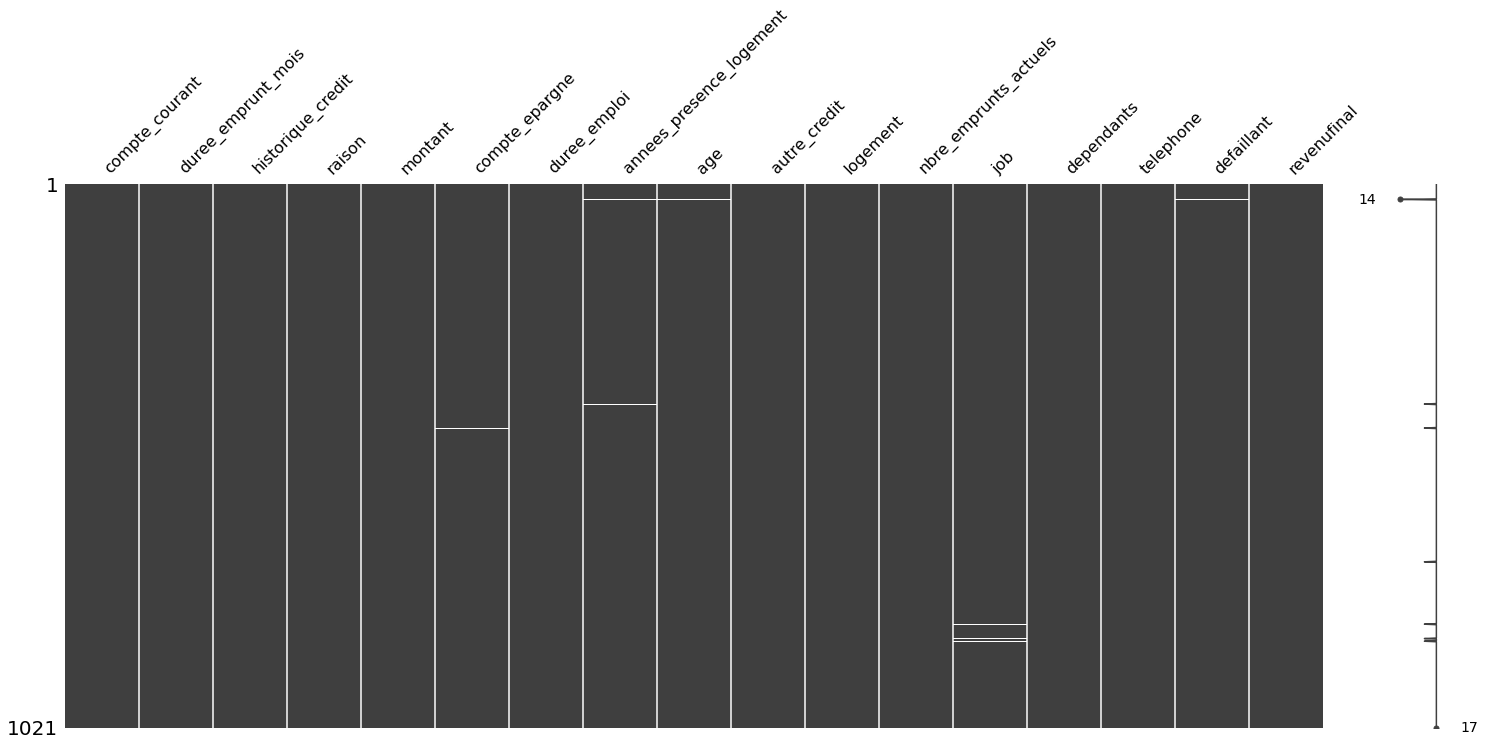

In [11]:
missingno.matrix(data)

1 individual seems to have 3 missing values (wile the other ones have less than 1). Maybe we should drop it to avoid NANs-correlations.

## Distributions

**Categorical**

In [12]:
def hist_plotter(data, x):
  to_plot = data[x].fillna("NAN")
  ax = sns.histplot(to_plot)
  ax.set_xlabel('values', fontsize = 15)
  ax.set_ylabel('count', fontsize = 15)
  title('Histogram of ' + x)

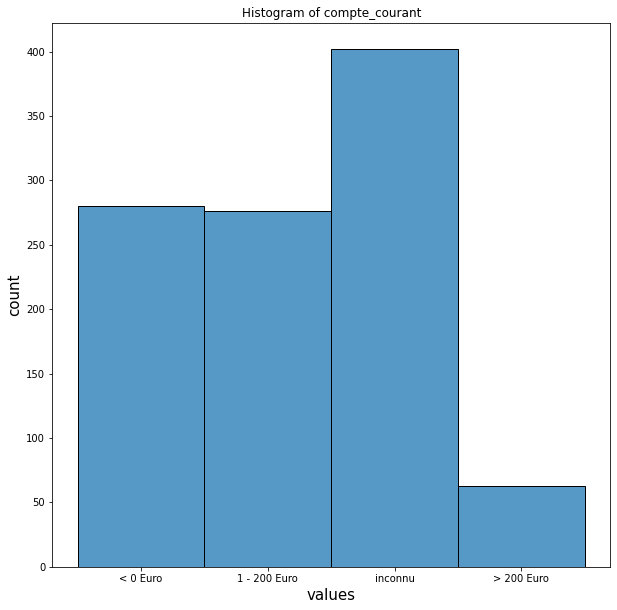

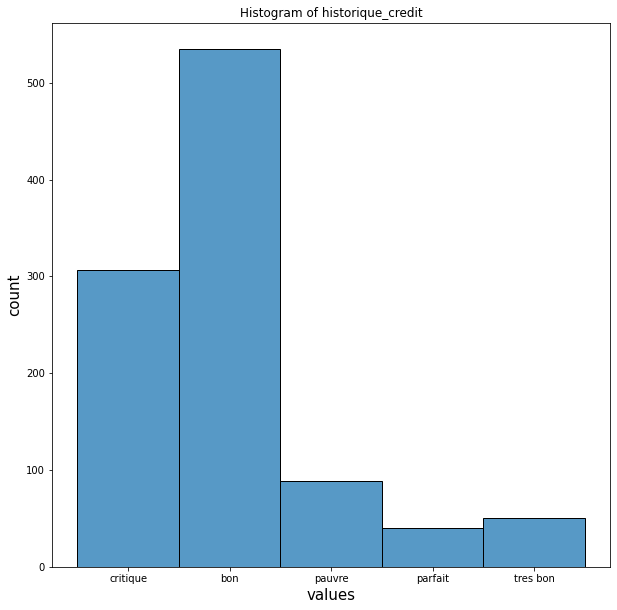

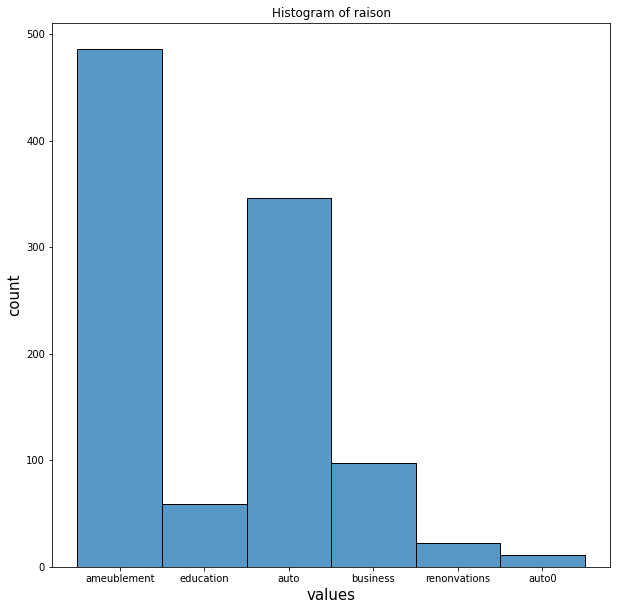

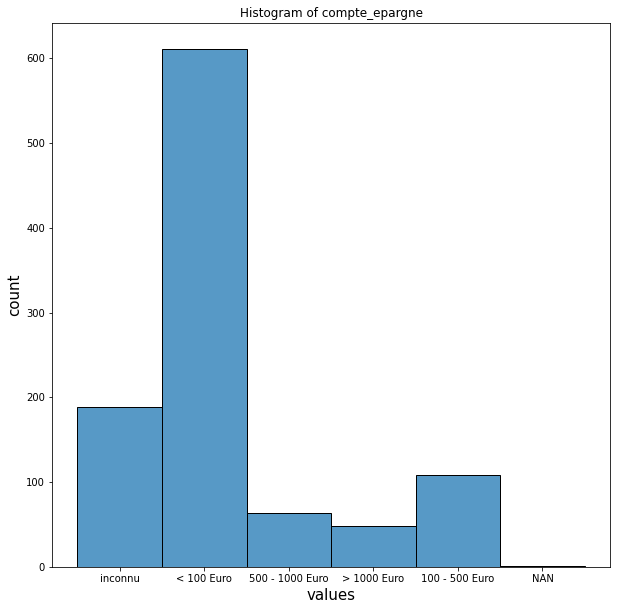

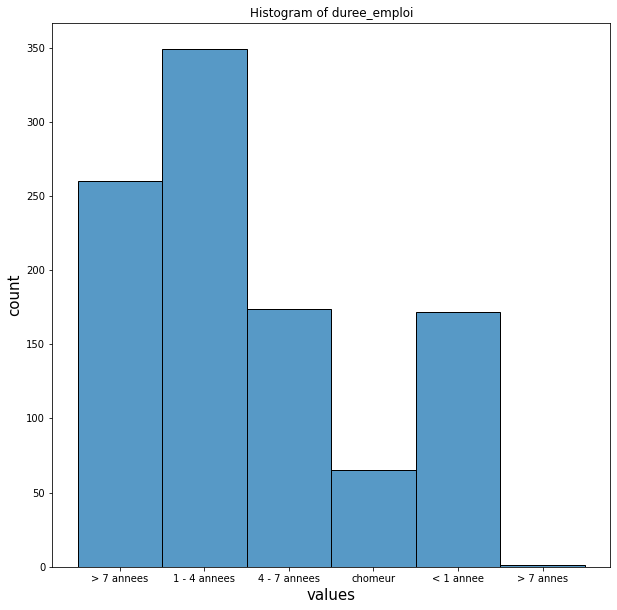

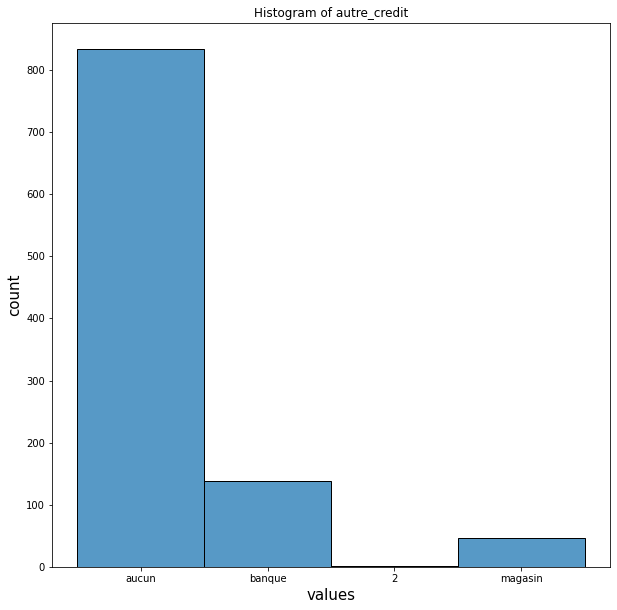

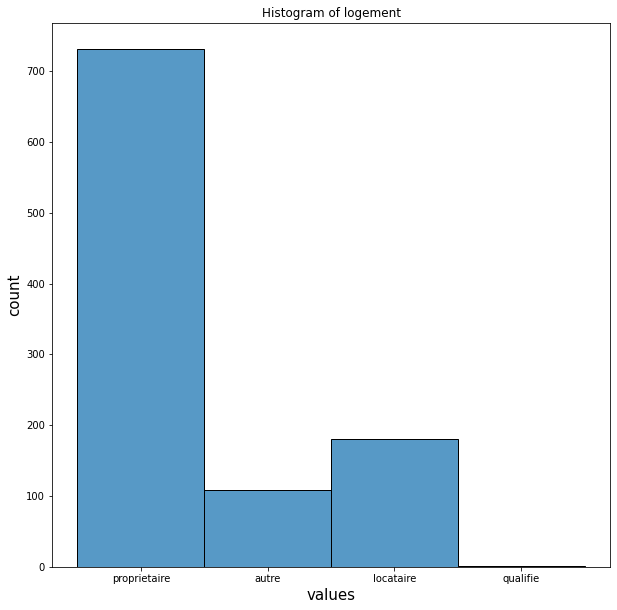

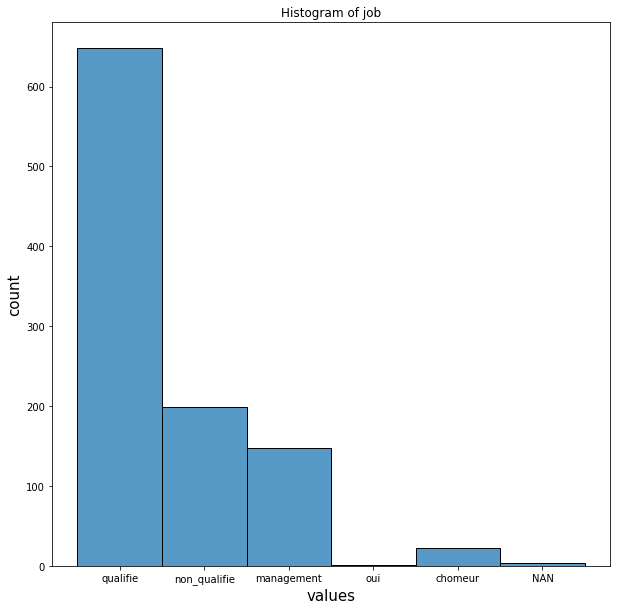

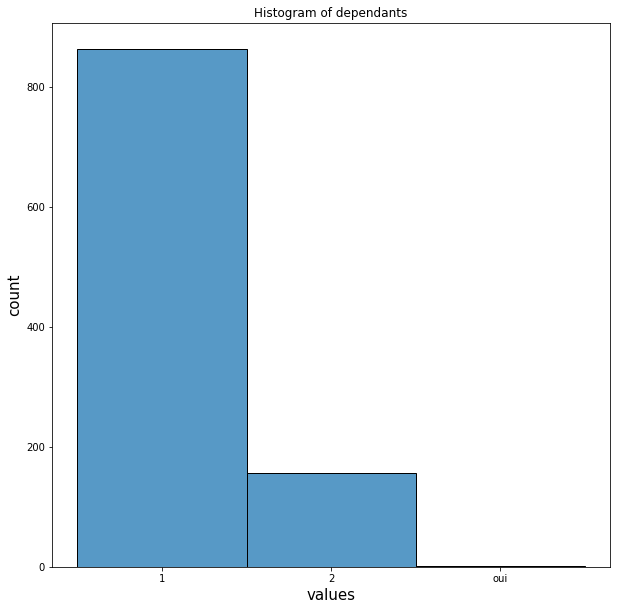

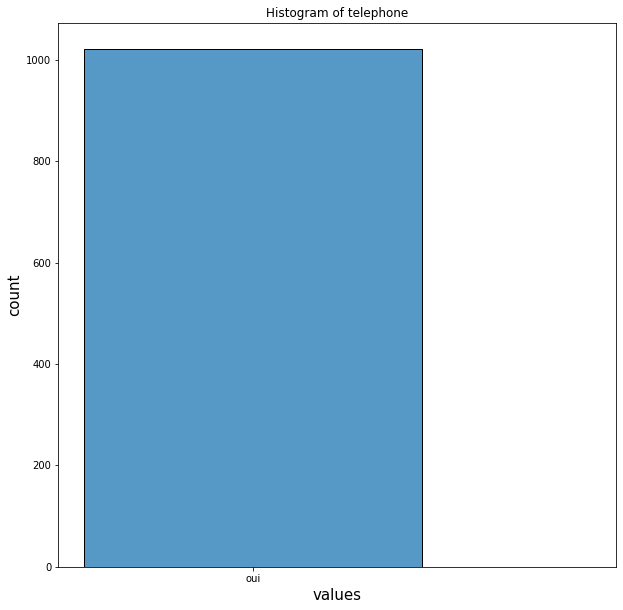

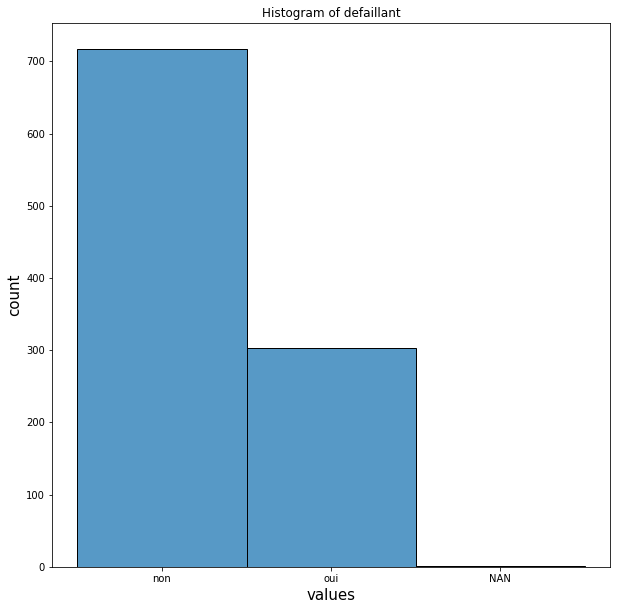

In [13]:
for x in categorical : 
  figure(figsize = (10,10))
  hist_plotter(data, x)
    

- \> 7 annes for duree_emploi is very unfrequent.

- idem for 2 in autre_credit

- idem for 'qualifie' in logment

- idem for oui in job/dependants

In [14]:
def hist_cdf_plotter(data, x) :

  figure(figsize=(20, 20))

  subplot(2,1,1)
  to_plot1 = data[x].fillna("NAN")
  ax1 = sns.distplot(to_plot1)
  ax1.set_xlabel('values')
  ax1.set_ylabel('count')
  title('Histogram of ' + x)
  

  subplot(2,1,2)
  to_plot2 = data[x].dropna()
  ax2 = sns.distplot(to_plot2, hist_kws = dict(cumulative=True), kde_kws = dict(cumulative=True))
  title('CDF of '+ x)
  grid(True)
  xlabel('x values')
  ylabel('P(x<=t)')

  show((ax1, ax2))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


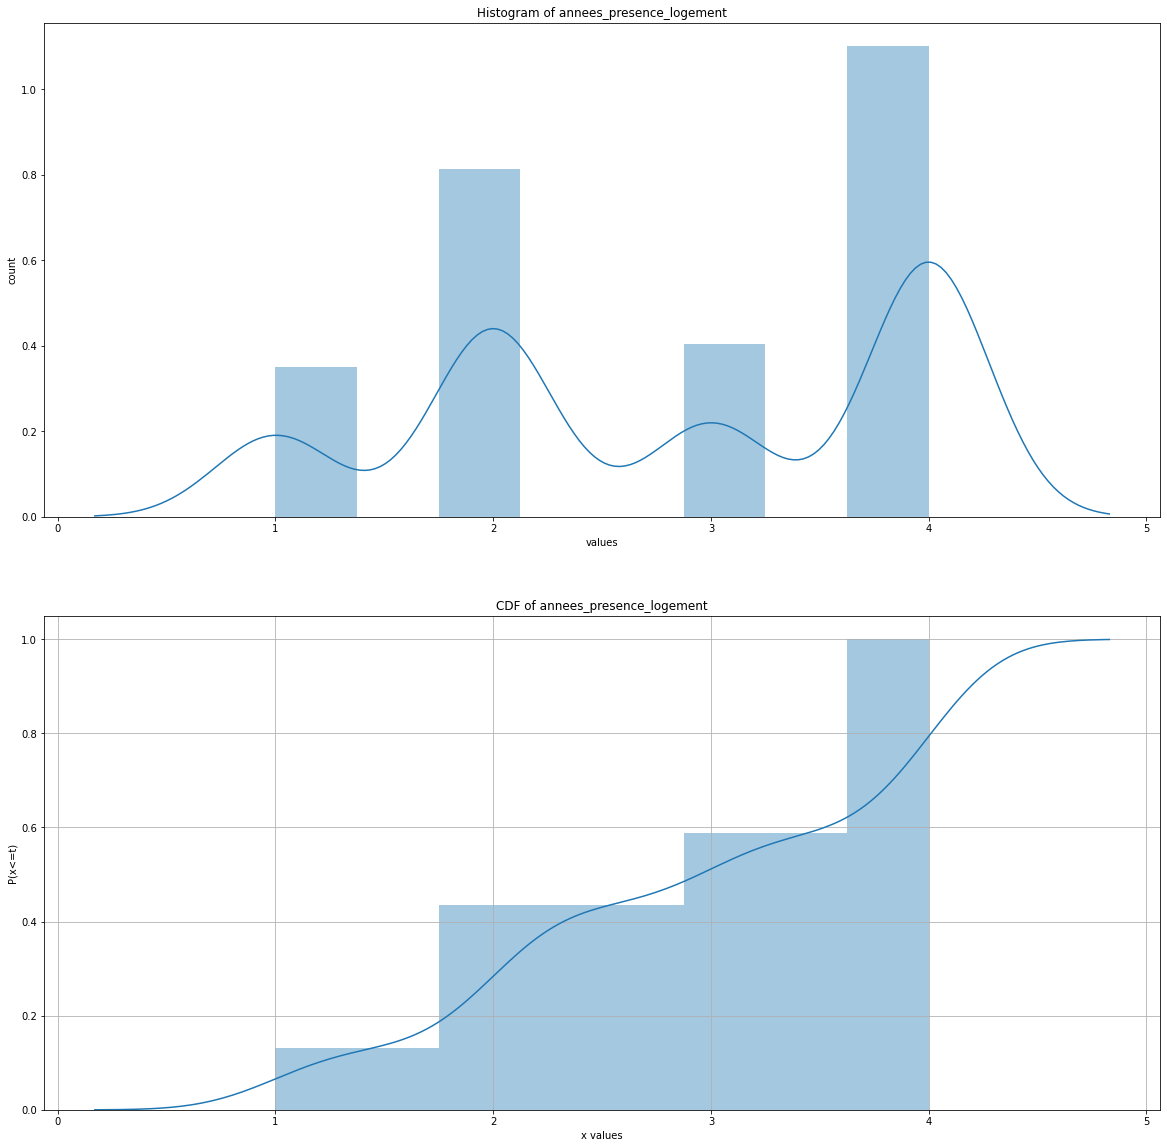

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


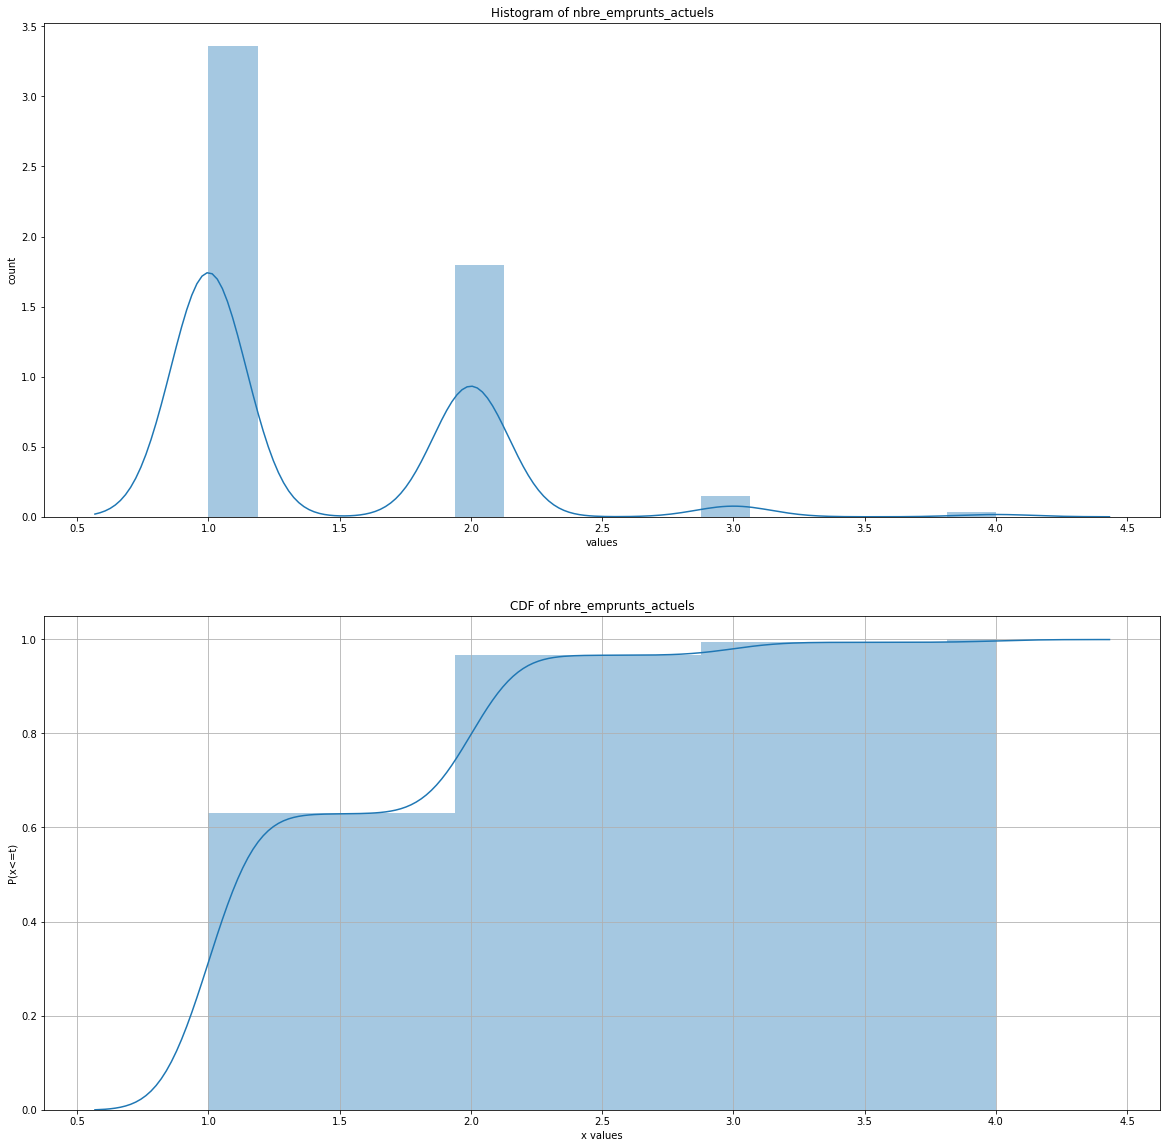

In [15]:
for x in ["annees_presence_logement", "nbre_emprunts_actuels"]:
  hist_cdf_plotter(data, x)

nbre_emprunts_actuels unbalanced

In [16]:
def numerical_plotter(data, x, take_log = False) :

  to_plot = data[x].dropna()

  if take_log : to_plot = log(to_plot)

  figure(figsize = (10,10))
  ax1 = sns.kdeplot(to_plot)
  ax1.set_xlabel('values')
  ax1.set_ylabel('P(X = t)')
  title('Density of ' + x)
  show(ax1)
  

  figure(figsize = (10,10))
  ax2 = sns.kdeplot(to_plot, cumulative = True)
  title('CDF of '+ x)
  grid(True)
  xlabel('x values')
  ylabel('P(x<=t)')
  show(ax2)

  figure(figsize = (10,10))
  statsmodels.api.qqplot(to_plot, fit = True) #default dist : norm
  title("qqplot of " + x)
  show()

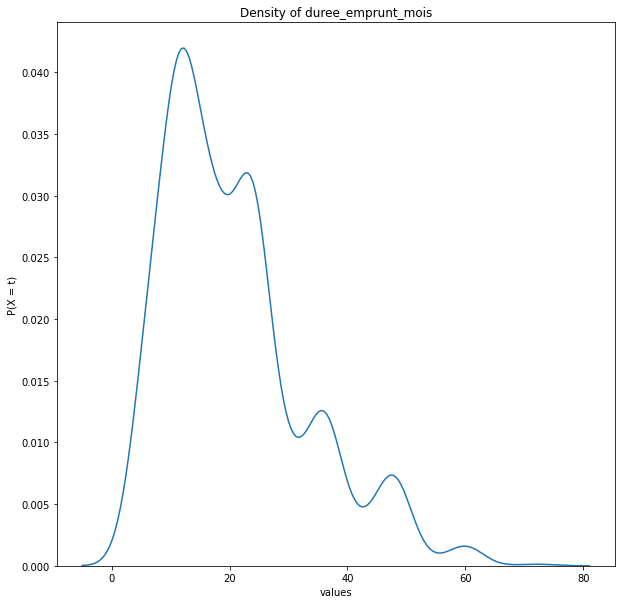

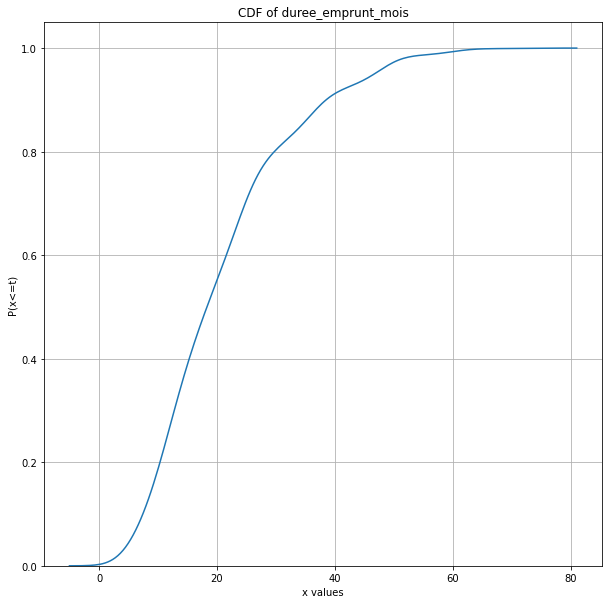

<Figure size 720x720 with 0 Axes>

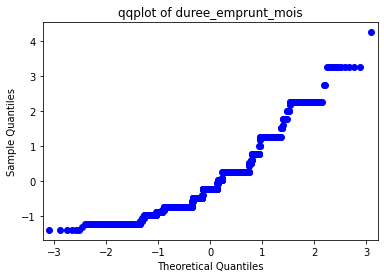

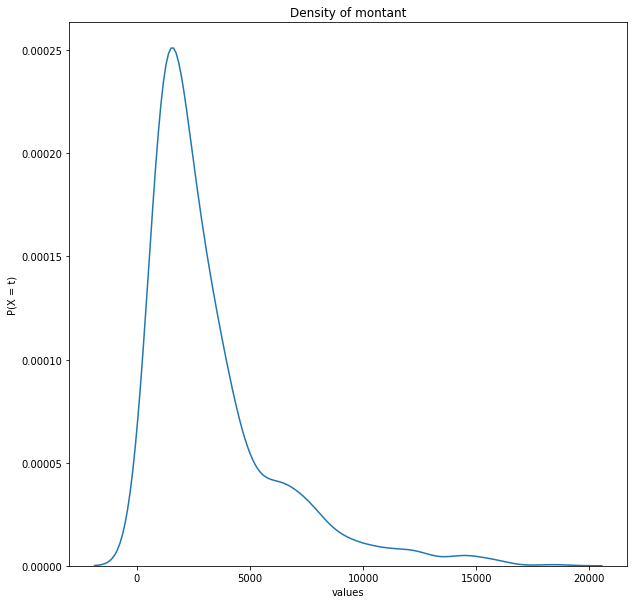

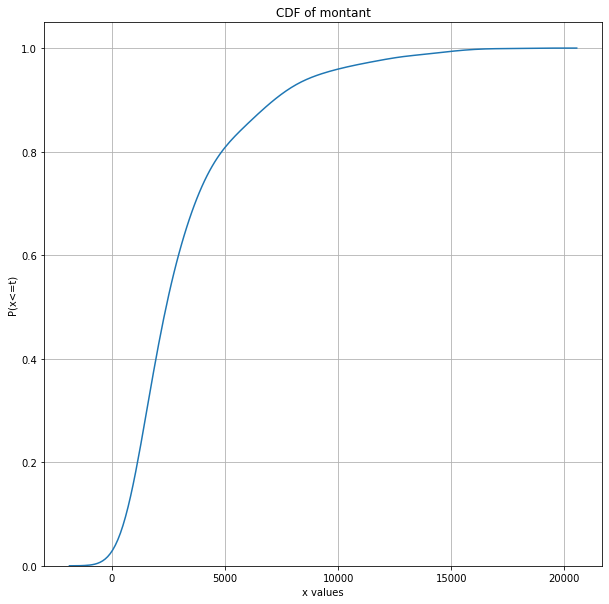

<Figure size 720x720 with 0 Axes>

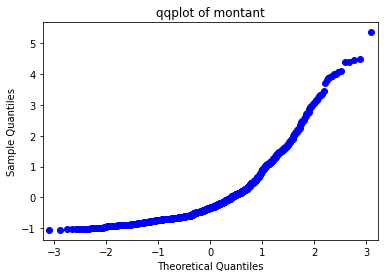

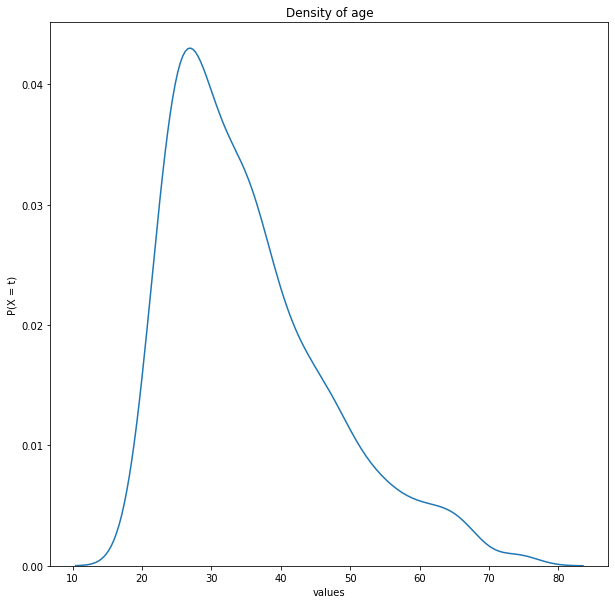

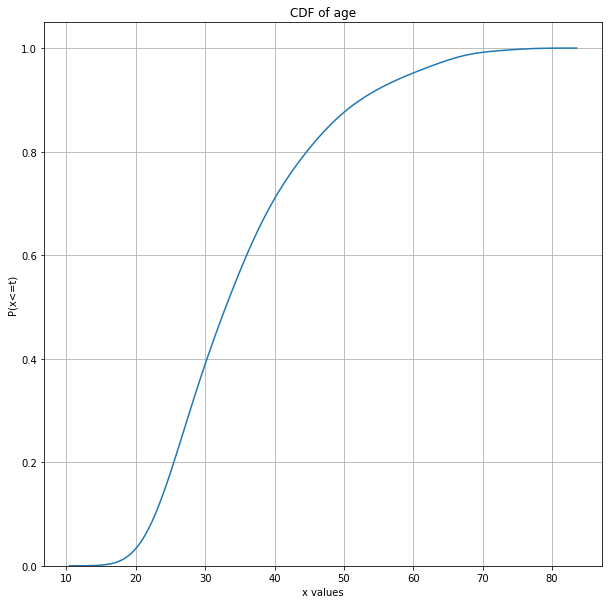

<Figure size 720x720 with 0 Axes>

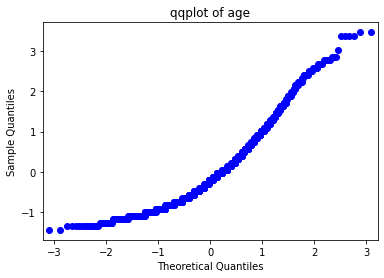

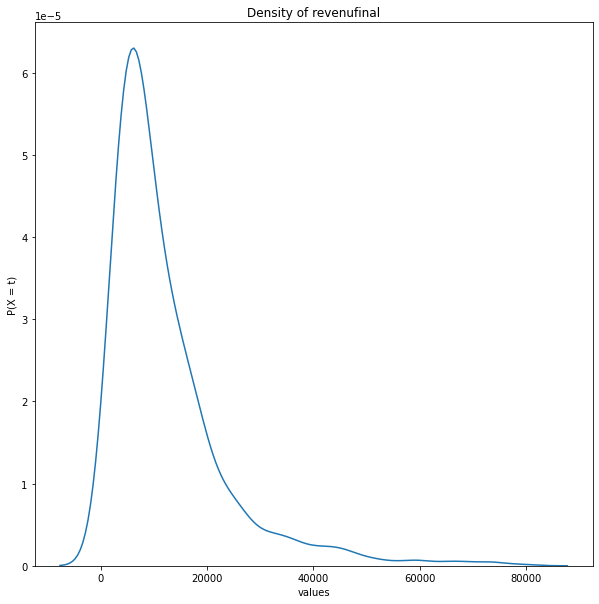

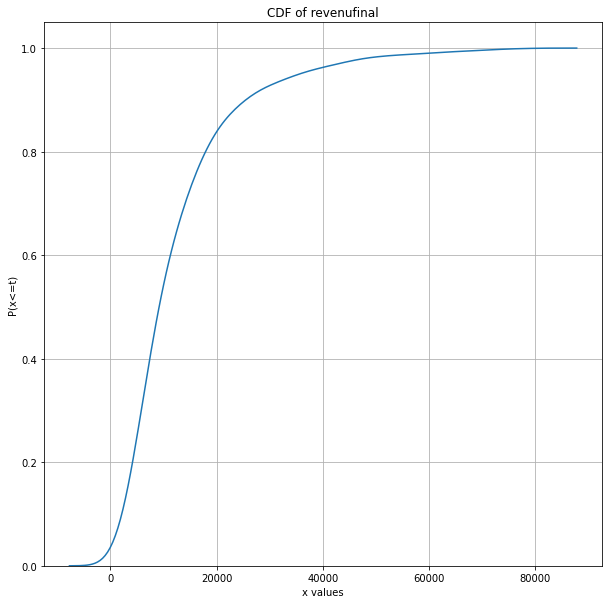

<Figure size 720x720 with 0 Axes>

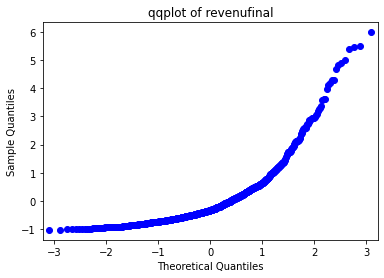

In [17]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"]: continue
  numerical_plotter(data, x)

Only skewed-gaussians.

To take it gaussians we would need to take the log.

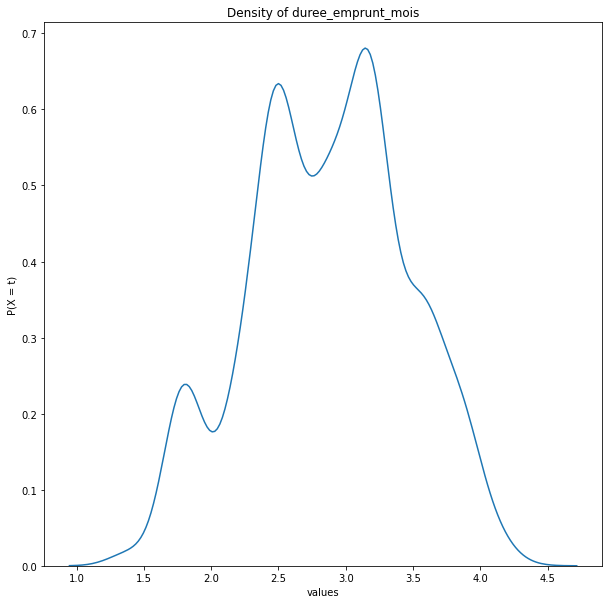

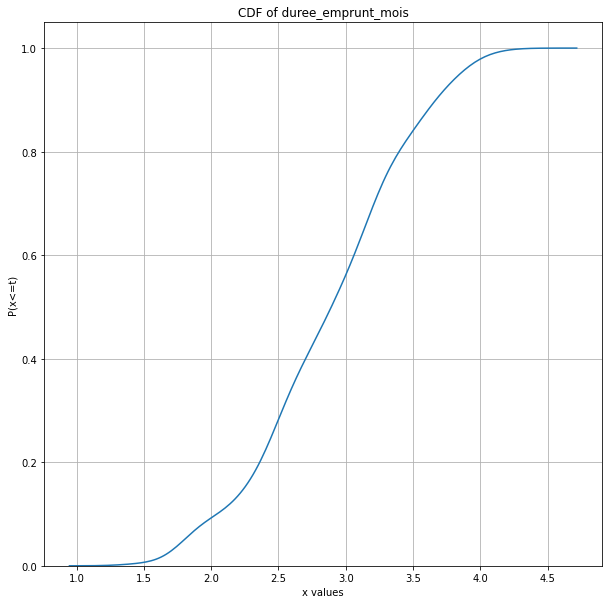

<Figure size 720x720 with 0 Axes>

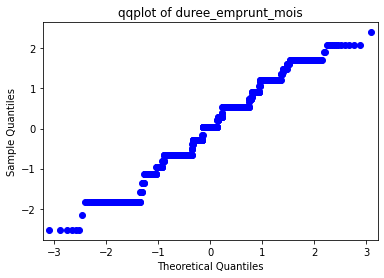

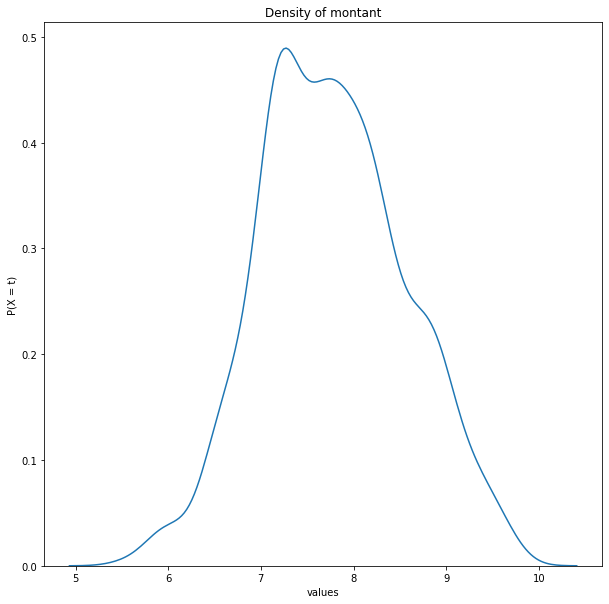

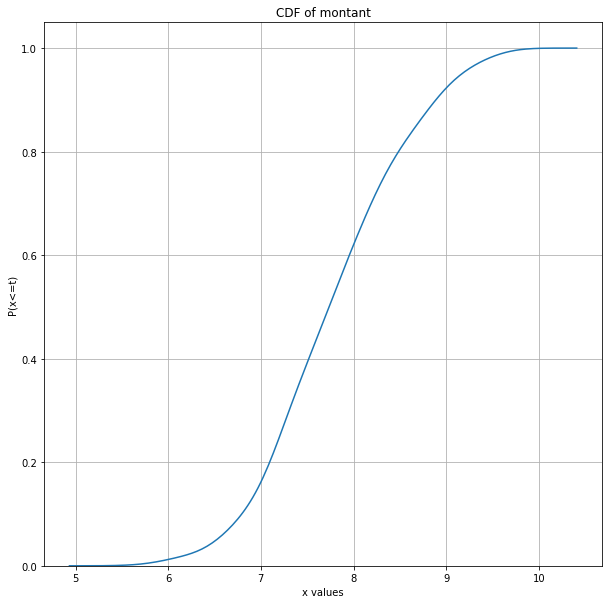

<Figure size 720x720 with 0 Axes>

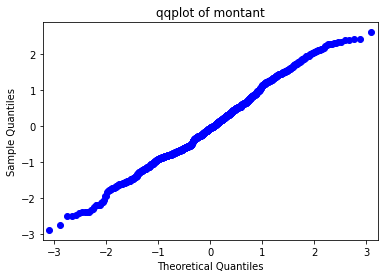

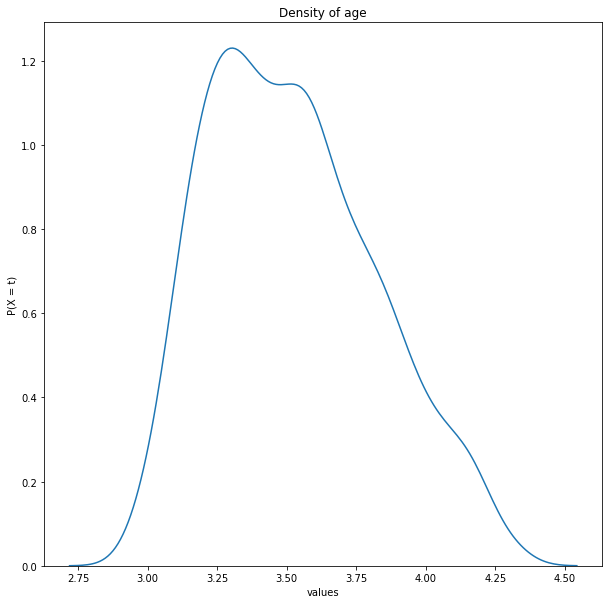

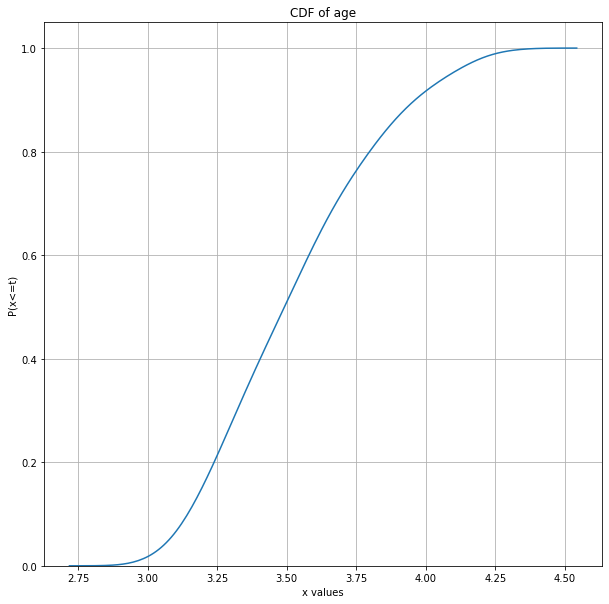

<Figure size 720x720 with 0 Axes>

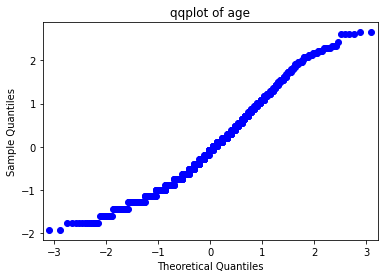

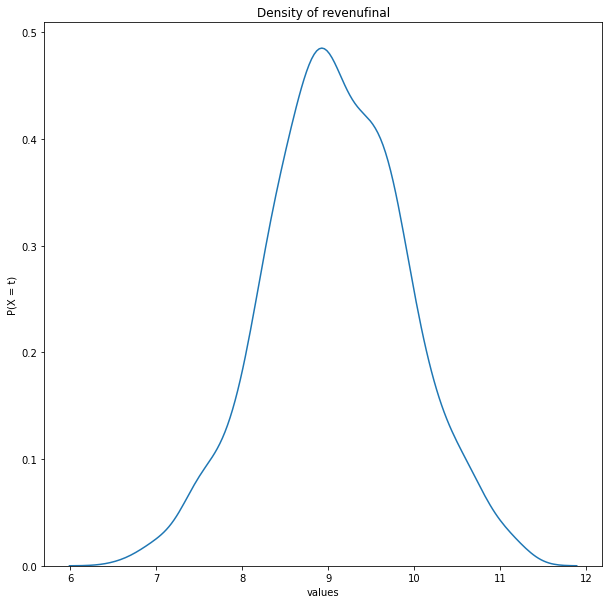

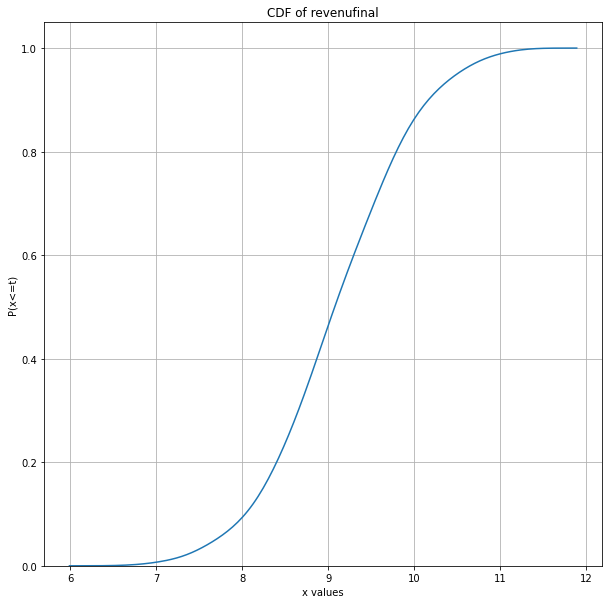

<Figure size 720x720 with 0 Axes>

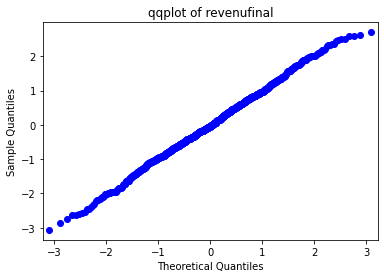

In [18]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"]: continue
  numerical_plotter(data, x, take_log = True)

#3. Multivariate Analysis



**Executive summary**

-Pearson's correlation plots (ok because we will perform a linear model so we do not need a copule).

-Joint distributions (boxplots/conditionnal densities for target vs categorical / countours for target vs  numerical).

## Categorical

In [19]:
def target_vs_categorical(data, target, x) : 
    
    Xy = pd.DataFrame( (data[x], data[target]) ).transpose()

    print("#############Response vs " + x + "##############")

    print("_____________Pivot_______________")
    figsize = (10, 10)
    # Plot the orbital period with horizontal boxes
    sns.boxplot(x = x, 
                y = target, 
                data=Xy,
                whis=[0, 100], 
                width=.6, 
                palette="vlag")

    # Add in points to show each observation
    sns.stripplot(x = x, 
                  y = target, 
                  data=Xy,
                  size=4, 
                  color=".3", 
                  linewidth=0)
    show()

    print("______________Conditionnal Distribution_______________")
    figsize = (10, 10)
    try : 
      Xy[x] = Label_Encoder().fit_transform(Xy[x])
      sns.displot(x = target, hue = x, data = Xy, kde = True, fill = True)
      show()
    except : 
      sns.displot(Xy, x = target, hue = x, fill = True)
      show()

#############Response vs compte_courant##############
_____________Pivot_______________


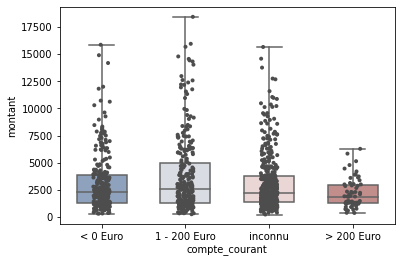

______________Conditionnal Distribution_______________


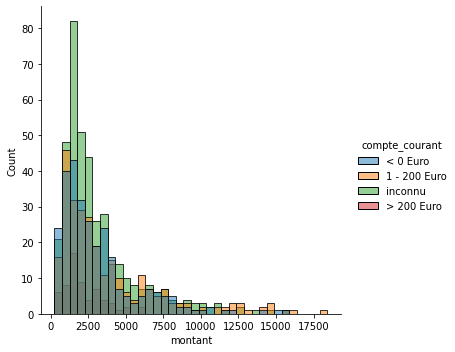

#############Response vs historique_credit##############
_____________Pivot_______________


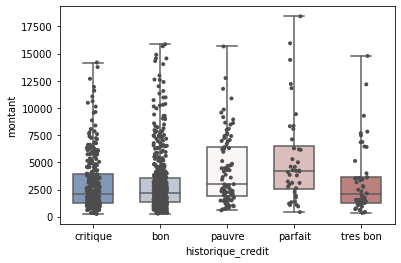

______________Conditionnal Distribution_______________


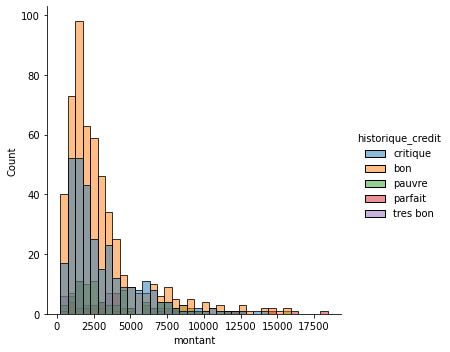

#############Response vs raison##############
_____________Pivot_______________


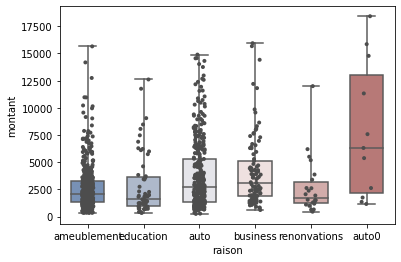

______________Conditionnal Distribution_______________


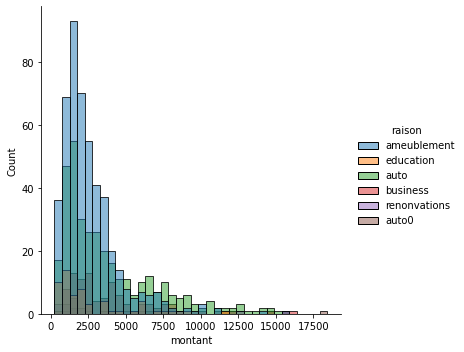

#############Response vs compte_epargne##############
_____________Pivot_______________


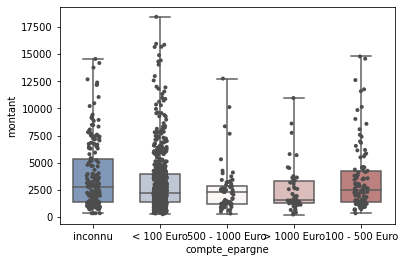

______________Conditionnal Distribution_______________


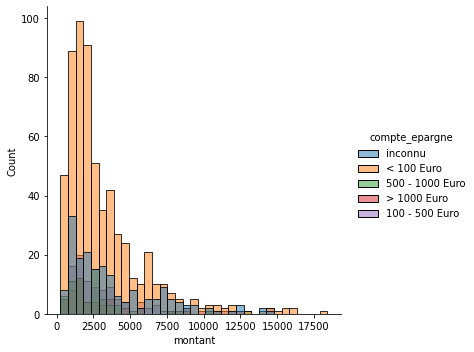

#############Response vs duree_emploi##############
_____________Pivot_______________


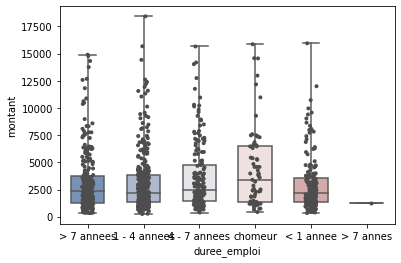

______________Conditionnal Distribution_______________


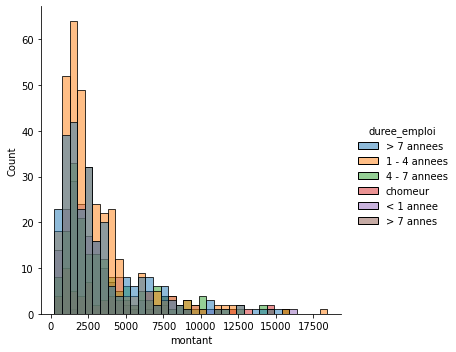

#############Response vs autre_credit##############
_____________Pivot_______________


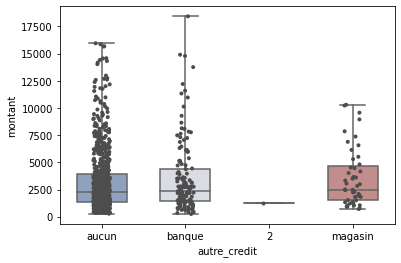

______________Conditionnal Distribution_______________


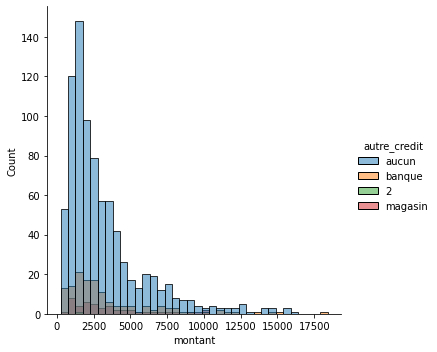

#############Response vs logement##############
_____________Pivot_______________


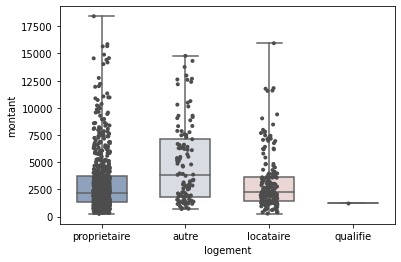

______________Conditionnal Distribution_______________


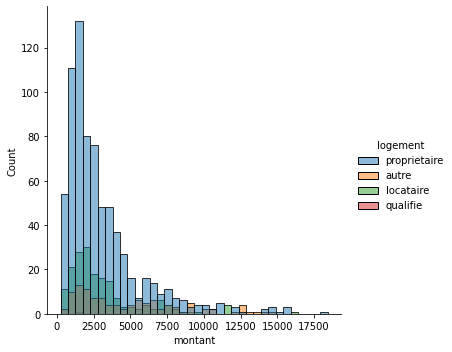

#############Response vs job##############
_____________Pivot_______________


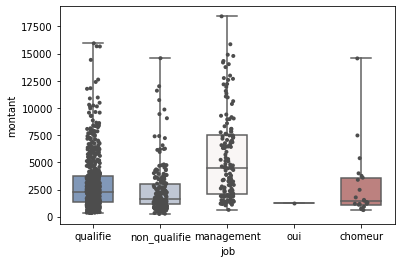

______________Conditionnal Distribution_______________


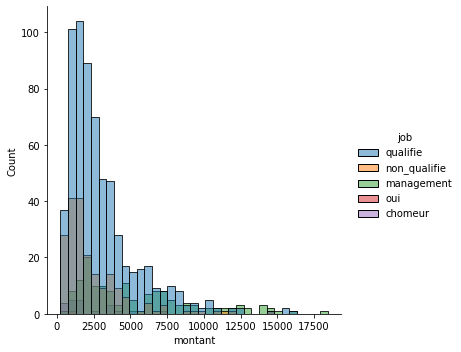

#############Response vs dependants##############
_____________Pivot_______________


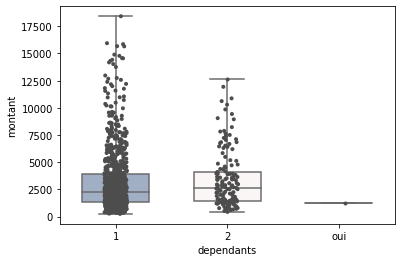

______________Conditionnal Distribution_______________


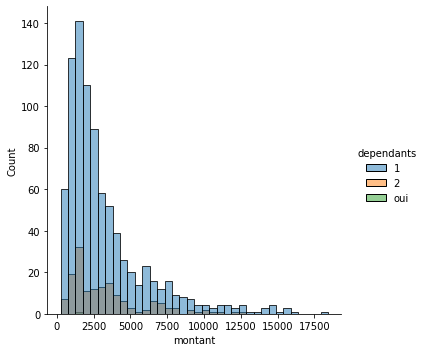

#############Response vs telephone##############
_____________Pivot_______________


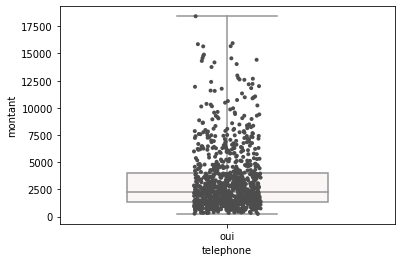

______________Conditionnal Distribution_______________


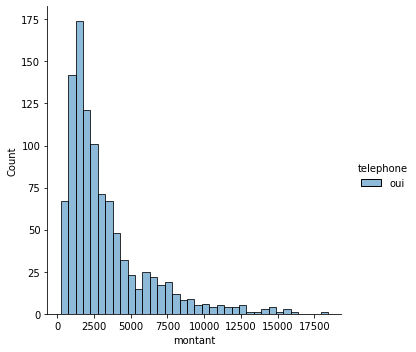

#############Response vs defaillant##############
_____________Pivot_______________


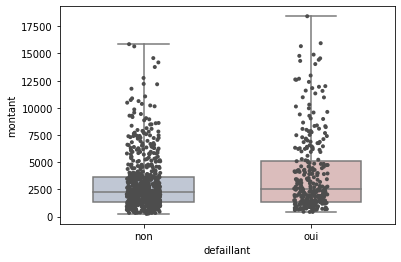

______________Conditionnal Distribution_______________


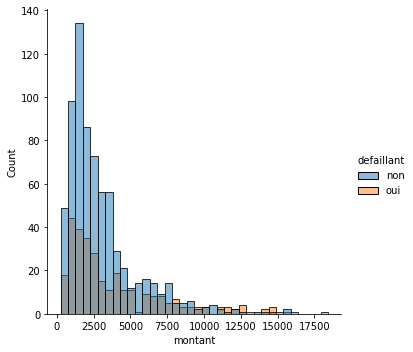

#############Response vs annees_presence_logement##############
_____________Pivot_______________


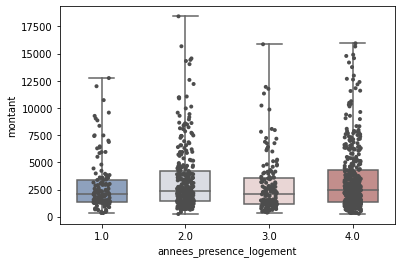

______________Conditionnal Distribution_______________


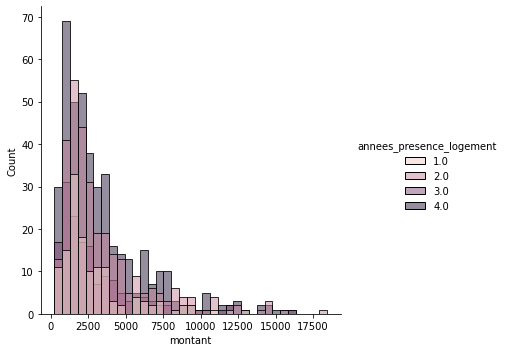

#############Response vs nbre_emprunts_actuels##############
_____________Pivot_______________


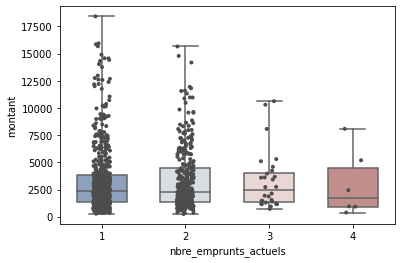

______________Conditionnal Distribution_______________


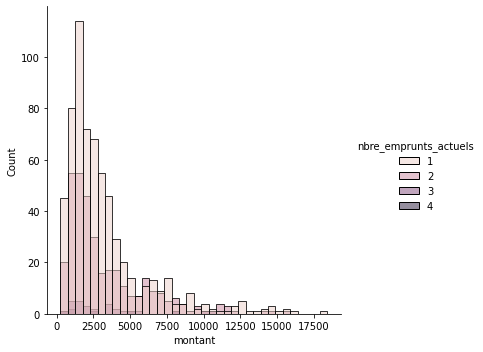

In [20]:
for x in categorical:
  target_vs_categorical(data, "montant", x)

for x in ["annees_presence_logement", "nbre_emprunts_actuels"]:
  target_vs_categorical(data, "montant", x)

- Most of these variables do not seem very discriminant : They would not be selected by Lasso.

- We must remove the too rare modalities.

## Numerical

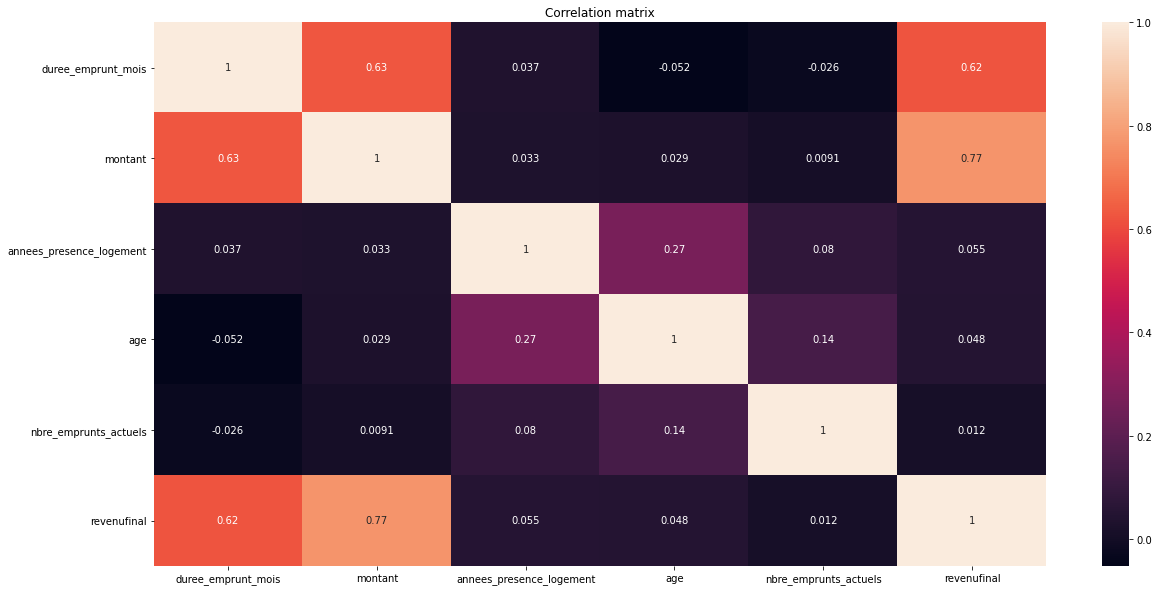

In [21]:
corrMatrix = pd.DataFrame(data[numerical].corr(method = 'pearson'))
figsize(20,10)
sns.heatmap(corrMatrix, annot=True)
title('Correlation matrix')
show()

- only positive correlations or ~0

- Strong correlations (\> 1/2) :duree_emprunt_mois / revenufinal / montant

In [22]:
def quantitative_vs_response(data, target, x):
    
      Xy = pd.DataFrame( (data[x], data[target]) ).transpose()

      print("#############Response vs " + x + "##############")

      figsize(10, 10)
      sns.kdeplot(data = Xy, 
                  x = x, 
                  y = target, 
                  fill=True, 
                  thresh=0, 
                  levels=100, 
                  cmap="mako")
      show()

#############Response vs duree_emprunt_mois##############


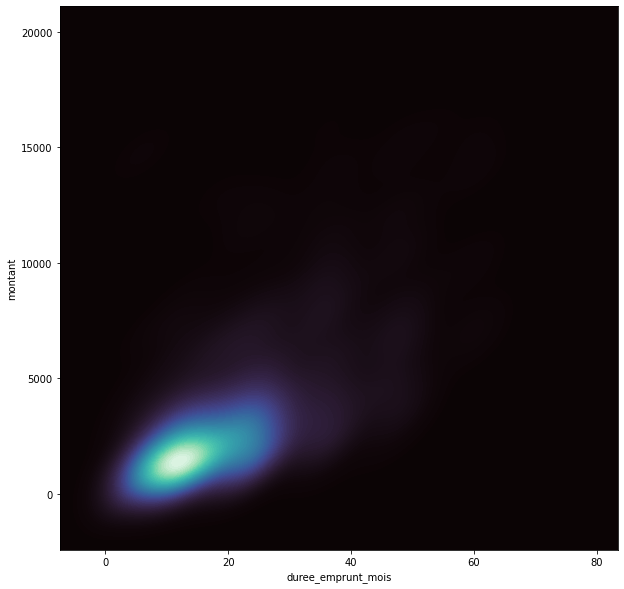

#############Response vs age##############


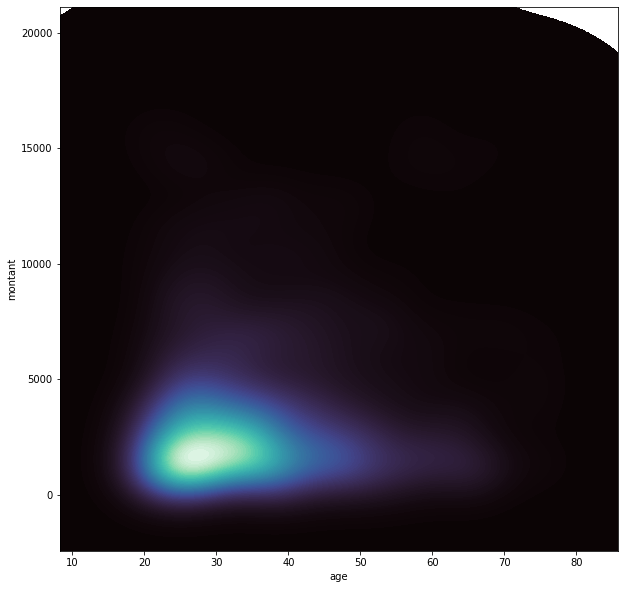

#############Response vs revenufinal##############


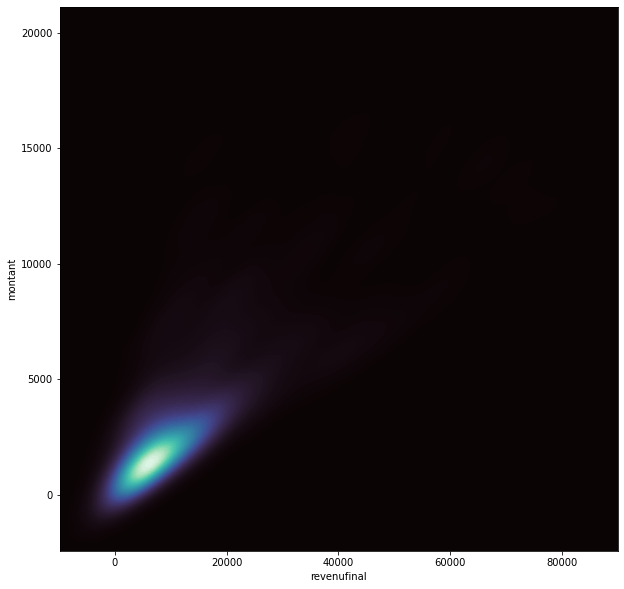

In [23]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels", "montant"]: continue
  quantitative_vs_response(data, 'montant', x)

They seem more interesting. Especially age.

# 4. Preporcessing

- train/test/split

- missing values replacement

- remove unintersting variable/modalities

- log-numerical

- dummies

- standard scaler

In [24]:
X = data.copy()
del X["montant"]
y = data["montant"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

**Missing values**

In this problem there is only a few missing values, so that it might work to replace NAs with mean/median/mode. But in practice it is a really bad idea (it reduces the variance/distance between data that we actually want to learn). We prefer an iterative Inputer.

Let's also note that we'll consider a missing value as a modality for categorical data.

In [25]:
numerical.remove("montant")

In [26]:
imputer1 = IterativeImputer(initial_strategy="mean")

imputer1.fit(X_train[numerical])

X_train[numerical] = imputer1.transform(X_train[numerical])
X_test[numerical] = imputer1.transform(X_test[numerical])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [27]:
X_train[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,20.796919,2.847339,35.450980,1.383754,12195.808628
std,11.949376,1.102312,11.532671,0.543806,10853.725139
min,4.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,2.000000,26.000000,1.000000,5270.285248
50%,18.000000,3.000000,33.000000,1.000000,8888.501218
75%,24.000000,4.000000,41.750000,2.000000,15525.570826
max,60.000000,4.000000,75.000000,4.000000,79354.527366


In [28]:
X_test[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,307.000000,307.000000,307.000000,307.000000,307.000000
mean,20.710098,2.838883,35.585095,1.469055,12452.772200
std,12.301389,1.107222,11.067277,0.642849,11984.804925
min,4.000000,1.000000,20.000000,1.000000,1047.558564
25%,12.000000,2.000000,27.000000,1.000000,4916.968071
50%,18.000000,3.000000,33.000000,1.000000,8186.131406
75%,24.000000,4.000000,42.000000,2.000000,15509.713883
max,72.000000,4.000000,75.000000,4.000000,73359.432214


**Dummies**

Options : drop_first = True ! (Because X must be full rank)

It will drop out telephone.

After we'll sum columns (with 0/1) and remove columns whose sum is less than 10 (too unbalanced).

In [29]:
class sk_dummies():

  def __init__(self, categorical = None, drop_n = None) :
    self.categorical = categorical
    self.drop_n = drop_n


  def fit(self, X, transform = False) :
    if self.categorical != None: 
      X2 = pd.get_dummies(X, 
                         dummy_na = True, 
                         columns = categorical, 
                         drop_first = True)
    else :
      X2 = pd.get_dummies(X, 
                          dummy_na = True, 
                          drop_first = True)
    
    if self.drop_n != None :

      to_remove = sum(X2.values, axis = 0) <= self.drop_n 
      names = list(X2.columns)

      for i in range(len(to_remove)):
        if to_remove[i]: del X2[names[i]]


    self.to_keep = list(X2.columns)
      
    if transform : return X2

  def transform(self, X):

    if self.categorical != None: 
      X2 = pd.get_dummies(X, 
                         dummy_na = True, 
                         columns = categorical, 
                         drop_first = True)
    else :
      X2 = pd.get_dummies(X, 
                          dummy_na = True, 
                          drop_first = True)
      
    for x in list(X2.columns):
      if not x in self.to_keep :
        del X2[x]
    
    for x in self.to_keep :
      if not x in list(X2.columns):
        X2[x] = zeros(X2.shape[0])

    return X2

  def fit_transform(self, X):
    return self.fit(X, transform = True)
    

In [30]:
skdummies_instance = sk_dummies(categorical, drop_n = 10)
X_train = skdummies_instance.fit_transform(X_train)
X_train.shape

(714, 33)

In [31]:
X_test = skdummies_instance.transform(X_test)
X_test.shape

(307, 33)

In [32]:
X_train.head()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal,compte_courant_< 0 Euro,compte_courant_> 200 Euro,compte_courant_inconnu,historique_credit_critique,historique_credit_parfait,historique_credit_pauvre,historique_credit_tres bon,raison_auto,raison_business,raison_education,raison_renonvations,compte_epargne_500 - 1000 Euro,compte_epargne_< 100 Euro,compte_epargne_> 1000 Euro,compte_epargne_inconnu,duree_emploi_4 - 7 annees,duree_emploi_< 1 annee,duree_emploi_> 7 annees,duree_emploi_chomeur,autre_credit_banque,autre_credit_magasin,logement_locataire,logement_proprietaire,job_management,job_non_qualifie,job_qualifie,dependants_2,defaillant_oui
144,27.0,2.0,27.0,1.0,13549.610137,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
211,12.0,2.0,55.0,1.0,6483.458220,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
511,9.0,4.0,49.0,1.0,3102.007019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
713,48.0,4.0,46.0,2.0,27215.634085,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
822,6.0,3.0,26.0,1.0,2726.429304,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


**Take log numerical**

In [33]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"] : continue
  else :
    X_train[x] = log(X_train[x])
    X_test[x] = log(X_test[x])



In [34]:
y_train = log(y_train)
y_test = log(y_test)

In [35]:
X_train[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,2.870003,2.847339,3.520418,1.383754,9.092595
std,0.587842,1.102312,0.303187,0.543806,0.805266
min,1.386294,1.000000,2.944439,1.000000,6.599157
25%,2.484907,2.000000,3.258097,1.000000,8.569840
50%,2.890372,3.000000,3.496508,1.000000,9.092507
75%,3.178054,4.000000,3.731645,2.000000,9.650220
max,4.094345,4.000000,4.317488,4.000000,11.281681


# 5. Linear Model

**With statsmodels** 

https://stackoverflow.com/questions/46607831/python-linear-regression-diagnostic-plots-similar-to-r

In [36]:
lm = statsmodels.api.OLS(endog=y_train, exog=X_train).fit()
influence = lm.get_influence()

res = X_train.copy()
res['resid'] = lm.resid
res['fittedvalues'] = lm.fittedvalues
res['resid_std'] = lm.resid_pearson
res['leverage'] = influence.hat_matrix_diag

print(lm.summary())


                                 OLS Regression Results                                
Dep. Variable:                montant   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              5939.
Date:                Fri, 28 May 2021   Prob (F-statistic):                        0.00
Time:                        14:55:02   Log-Likelihood:                         -457.94
No. Observations:                 714   AIC:                                      981.9
Df Residuals:                     681   BIC:                                      1133.
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

As expected most of variables have no (singlewise) impact on target. A simple variable selection is possible by dropping out all variables whose student test p-value > 5%. To avoid interaction effects we'll perform AIC/BIC/Lasso variable selections (but we expect that most of variables will have a weight of 0).

In [37]:
def plot_diagnosis(residuals):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.style.use('seaborn')

    # Residual against fitted values.
    residuals.plot.scatter(x='fittedvalues', y='resid', ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qqplot
    statsmodels.api.qqplot(
        residuals['resid'], dist=scipy.stats.t, fit=True, line='45',
        ax=axes[0, 1], c='#4C72B0'
    )
    axes[0, 1].set_title('Normal Q-Q')

    # The scale-location plot.
    residuals.plot.scatter(x='fittedvalues', y='resid_std', ax=axes[1, 0])
    axes[1, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 0].set_title('Scale-Location')

    # Standardized residuals vs. leverage
    residuals.plot.scatter(x='leverage', y='resid_std', ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 1].set_title('Residuals vs Leverage')

    tight_layout()
    show()


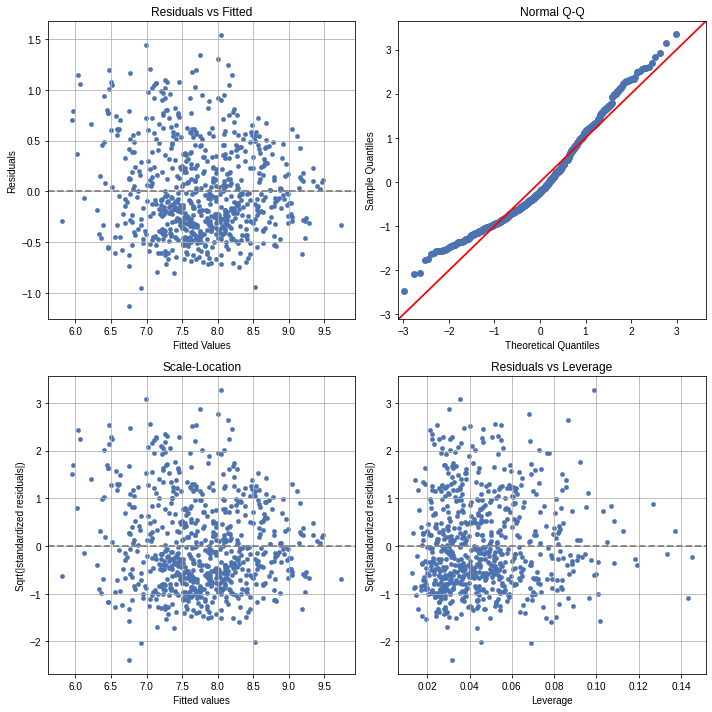

In [38]:
plot_diagnosis(res)

Residual vs fitted & scale location ok

QQ : could be better 

leverage : many points have a leverage > 1. But we do not have lots of individuals.

**Calibration/prediction score**

In [39]:
def adjusted_r2(fitted_model, X, y):
  n, p = X.shape
  return 1 - ( 1 - r2_score(y, fitted_model.predict(X)) ) * (n-1)/(n - p - 1)

In [40]:
sklearn_lm = LinearRegression(normalize = True)
sklearn_lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [41]:
def score_summary(X_train, y_train, X_test, y_test, model):

  scores = pd.DataFrame()
  scores["train"] = [mean_squared_error(y_train, model.predict(X_train)), 
                     r2_score(y_train, model.predict(X_train)), 
                     adjusted_r2(model, X_train, y_train)]
  scores["test"] = [mean_squared_error(y_test, model.predict(X_test)), 
                     r2_score(y_test, model.predict(X_test)), 
                     adjusted_r2(model, X_test, y_test)]
  scores.index = ['MSE', 'r2', 'adj r2']

  return scores

In [42]:
score_summary(X_train, y_train, X_test, y_test, sklearn_lm)

,train,test
MSE,0.203137,0.223576
r2,0.664703,0.642025
adj r2,0.648431,0.598754


The prediction scores are bad -14% r2 (overfitting!)!

Too few individuals in calibration database, no variable selection so too much noise, many categorical variables...

# 6. Regularization

## Ridge

In [43]:
coeffs = linspace(0, 1000, 10000)
#coeffs = log(coeffs)

In [44]:
def coeffs_cv_evol(model, 
                   X_train, 
                   y_train, 
                   params,
                   eval_set = None,
                   plot_coeffs = True,
                   plot_mse = True,
                   plot_r2 = True):

  coeffs = []
  errorstrain = []
  r2train = []
  if eval_set != None :
    errorstest = []
    r2test = []
    X_test = eval_set[0]
    y_test = eval_set[1]

  for a in params:

      model.set_params(alpha = a)
      model.fit(X_train, y_train)
      coeffs.append(model.coef_)

      mse_train = mean_squared_error(y_train, model.predict(X_train))
      errorstrain.append(mse_train) 
      r2_train = r2_score(y_train, model.predict(X_train))
      r2train.append(r2_train)

      if eval_set != None :
        mse_test = mean_squared_error(y_test, model.predict(X_test))
        errorstest.append(mse_test)
        r2_test = r2_score(y_test, model.predict(X_test))
        r2test.append(r2_test)
  
  # affichage evolution de la valeur des poids 7
  if plot_coeffs :
    figure(figsize=(10,10))
    ax = gca()
    ax.plot(params, coeffs)
    ax.set_xscale('log')
    xlabel('Param')
    ylabel('Weight')
    title('Weight~parameter')
    show()

  if plot_r2 :
    figure(figsize=(10,10))
    ax = gca()
    if eval_set != None : ax.plot(params, r2test)
    else : ax.plot(params, r2train)
    ax.set_xscale('log')
    title('R2~parameter')
    xlabel('Param')
    ylabel('r2')
    axis('tight')
    show()

  if plot_mse :
    figure(figsize=(10,10))
    ax = gca()
    if eval_set != None : ax.plot(params, errorstest)
    else : ax.plot(params, errorstrain)
    ax.set_xscale('log')
    title('mse~parameter')
    xlabel('Param')
    ylabel('r2')
    axis('tight')
    show()

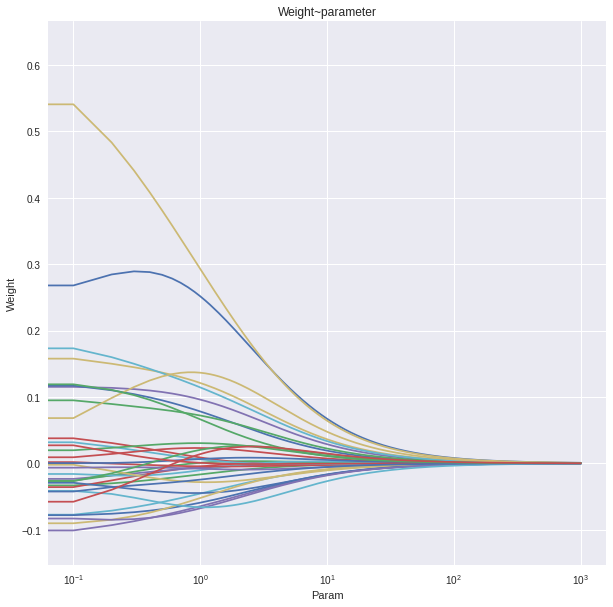

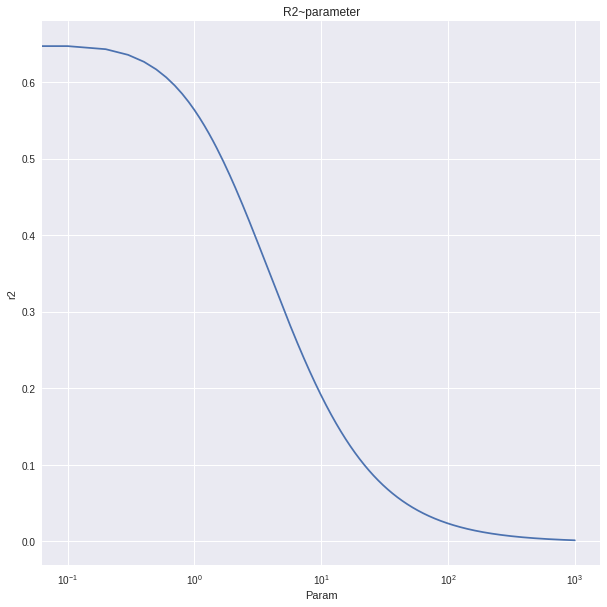

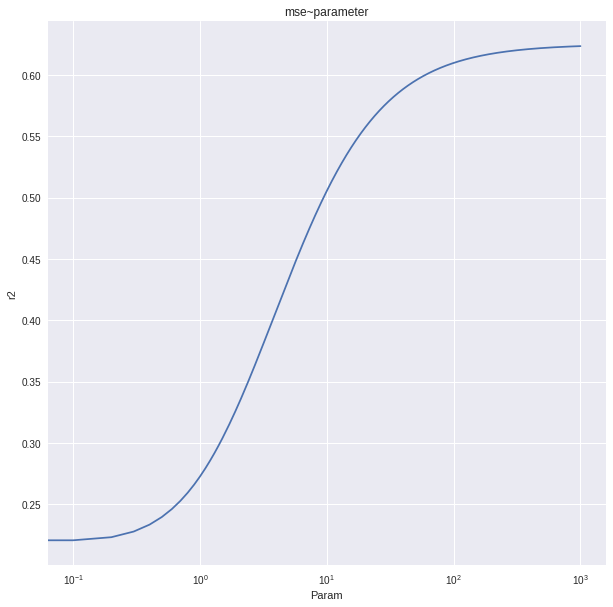

In [45]:
coeffs_cv_evol(Ridge(normalize = True), X_train, y_train, coeffs, eval_set = (X_test, y_test))

In [46]:
ridgecv = RidgeCV(alphas = coeffs, scoring = 'neg_mean_squared_error', normalize = True, cv = 5)
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([0.00000000e+00, 1.00010001e-01, 2.00020002e-01, ...,
       9.99799980e+02, 9.99899990e+02, 1.00000000e+03]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=True,
        scoring='neg_mean_squared_error', store_cv_values=False)

**Best Params**

In [47]:
ridgecv.alpha_

0.1000100010001

**Weights**

In [48]:
ridge_weights = zip(list(X_train.columns), ridgecv.coef_)
ridge_weights = pd.DataFrame(ridge_weights)
ridge_weights

,0,1
0,duree_emprunt_mois,0.267954
1,annees_presence_logement,-0.033209
2,age,-0.035774
3,nbre_emprunts_actuels,-0.023417
4,revenufinal,0.540699
5,compte_courant_< 0 Euro,-0.077305
6,compte_courant_> 200 Euro,-0.029240
7,compte_courant_inconnu,-0.026221
8,historique_credit_critique,0.037750
9,historique_credit_parfait,0.115202


**Assessment**

In [49]:
score_summary(X_train, y_train, X_test, y_test, ridgecv)

,train,test
MSE,0.205949,0.220631
r2,0.660061,0.646740
adj r2,0.643564,0.604039


The prediction/calibration scores are a bit better with Ridge than with OLS but it's still weak.

We'll have to select variables.

## LASSO

In [50]:
coeffs[0] = 1e-16

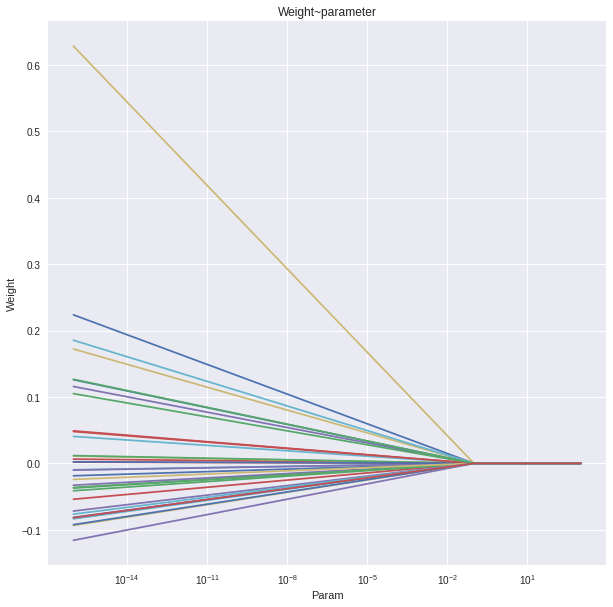

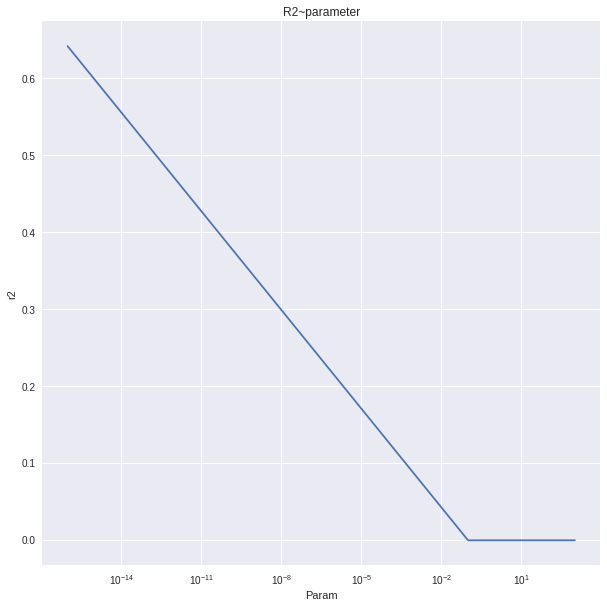

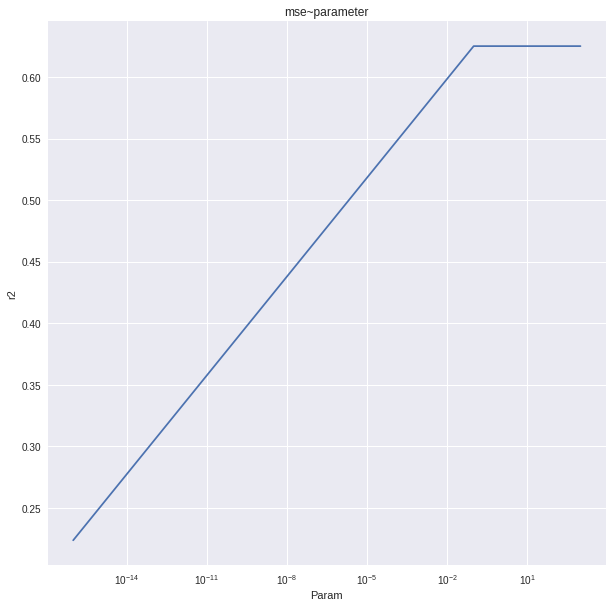

In [51]:
coeffs_cv_evol(Lasso(normalize = True), X_train, y_train, coeffs, eval_set = (X_test, y_test))

In [52]:
lassocv = LassoCV(alphas = coeffs, normalize = True, cv = 5, n_jobs = 5, max_iter = 2000)
lassocv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-16, 1.00010001e-01, 2.00020002e-01, ...,
       9.99799980e+02, 9.99899990e+02, 1.00000000e+03]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=2000,
        n_alphas=100, n_jobs=5, normalize=True, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

**Best param**

In [53]:
lassocv.alpha_

1e-16

Essentially similar to linear model (except for the gradient descent). 

**Weights**

In [54]:
lasso_weights = zip(list(X_train.columns), lassocv.coef_)
lasso_weights = pd.DataFrame(lasso_weights)
lasso_weights

,0,1
0,duree_emprunt_mois,0.223703
1,annees_presence_logement,-0.036325
2,age,-0.054065
3,nbre_emprunts_actuels,-0.032921
4,revenufinal,0.628408
5,compte_courant_< 0 Euro,-0.083619
6,compte_courant_> 200 Euro,-0.018731
7,compte_courant_inconnu,-0.037265
8,historique_credit_critique,0.048960
9,historique_credit_parfait,0.115780


In [55]:
score_summary(X_train, y_train, X_test, y_test, lassocv)

,train,test
MSE,0.203137,0.223576
r2,0.664703,0.642025
adj r2,0.648431,0.598754


Lasso do not work ! The introduction of bias (bad for linear regressions in general) is crtical compared to the noise reduction.

#Bonus BIC/AIC variable selection

In [56]:
aic = LassoLarsIC(criterion = 'aic')
aic.fit(X_train, y_train)
bic = LassoLarsIC(criterion = 'bic')
bic.fit(X_train, y_train)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, normalize=True, positive=False,
            precompute='auto', verbose=False)

In [57]:
score_summary(X_train, y_train, X_test, y_test, aic)

,train,test
MSE,0.211703,0.217232
r2,0.650564,0.652183
adj r2,0.633606,0.610139


In [58]:
score_summary(X_train, y_train, X_test, y_test, bic)

,train,test
MSE,0.231231,0.223922
r2,0.618331,0.641472
adj r2,0.599809,0.598134


In [59]:
bic_weights = zip(list(X_train.columns), bic.coef_)
bic_weights = pd.DataFrame(bic_weights)
bic_weights

,0,1
0,duree_emprunt_mois,0.152503
1,annees_presence_logement,0.000000
2,age,0.000000
3,nbre_emprunts_actuels,0.000000
4,revenufinal,0.599875
5,compte_courant_< 0 Euro,0.000000
6,compte_courant_> 200 Euro,0.000000
7,compte_courant_inconnu,0.000000
8,historique_credit_critique,0.000000
9,historique_credit_parfait,0.000000


Better prediction score with only 2 variables than with the complete linear model !

#Bonus : elastic-net

In [60]:
l1_ratios = linspace(1e-16, 1 - 1e-16, 10)

In [61]:
elastic_net = ElasticNetCV(l1_ratios, alphas = coeffs, max_iter = 10000, cv = 5, n_jobs = 5, tol = 1e-3, normalize = True)
elastic_net.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4966169321269831, tolerance: 0.3360636915851328
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1100516640970568, tolerance: 0.3360636915851328
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5158061445611679, tolerance: 0.34904257704486397
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to

ElasticNetCV(alphas=array([1.00000000e-16, 1.00010001e-01, 2.00020002e-01, ...,
       9.99799980e+02, 9.99899990e+02, 1.00000000e+03]),
             copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=array([1.00000000e-16, 1.11111111e-01, 2.22222222e-01, 3.33333333e-01,
       4.44444444e-01, 5.55555556e-01, 6.66666667e-01, 7.77777778e-01,
       8.88888889e-01, 1.00000000e+00]),
             max_iter=10000, n_alphas=100, n_jobs=5, normalize=True,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.001, verbose=0)

In [62]:
elastic_net.alpha_

1e-16

In [63]:
elastic_net.l1_ratio_

1e-16